# Ellipsoid of revolution

In [1]:
import numpy as np
import nutopy as nt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

## Metric and Hamiltonian

In [2]:
!pygmentize gfun.f90

subroutine gfun(x, a, b, c, g)

    double precision, intent(in)  :: x(2), a, b, c
    double precision, intent(out) :: g(2)

    double precision :: l1, l2, th1, th2

    th1 = x(1)
    th2 = x(2)

    l1 = a * sin(th1)**2 + b * cos(th1)**2
    l2 = b * cos(th2)**2 + c * sin(th2)**2

    g(1) = (l1-l2)*l1/(l1-c)
    g(2) = (l1-l2)*l2/(a-l2)

end subroutine gfun


In [3]:
!pygmentize hfun.f90

subroutine hfun(x, p, h, gfun)

    double precision, intent(in)  :: x(2), p(2)
    double precision, intent(out) :: h

    interface
        subroutine gfun(x, g)
        double precision, intent(in)  :: x(2)
        double precision, intent(out) :: g(2)
        end subroutine gfun
    end interface

    ! local variables
    double precision :: g(2), p1, p2

    p1  = p(1)
    p2  = p(2)

    call gfun(x, g)

    h = 0.5d0 * (p1**2 / g(1) + p2**2 / g(2))

end subroutine hfun


In [4]:
# Compilation of the metric and associated derivatives

!python -m numpy.f2py -c gfun.f90     -m gfun     > /dev/null 2>&1
!python -m numpy.f2py -c gfun_d.f90   -m gfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c gfun_d_d.f90 -m gfun_d_d > /dev/null 2>&1

from gfun     import gfun
from gfun_d   import gfun_d
from gfun_d_d import gfun_d_d

In [5]:
# Compilation of the hamiltonian and associated derivatives

!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

from hfun     import hfun     as hf
from hfun_d   import hfun_d   as hf_d
from hfun_d_d import hfun_d_d as hf_d_d

## Parameters

In [6]:
# Parameters

a = 1.0
b = 1.0
c = 0.25

theta1 = 0.0
theta2 = np.pi/2.0
x0     = np.array([theta1, theta2])

t0 = 0.0


## Hamiltonian, Flow and initial covector

In [7]:
# Hamiltonian and Flow

gf     = lambda x          : gfun(x, a, b, c)
dgf    = lambda x, dx      : gfun_d(x, dx, a, b, c)
d2gf   = lambda x, dx, d2x : gfun_d_d(x, dx, d2x, a, b, c)

hfun   = lambda t, x, p                   : hf(x, p, gf)
dhfun  = lambda t, x, dx, p, dp           : hf_d(x, dx, p, dp, dgf)
d2hfun = lambda t, x, dx, d2x, p, dp, d2p : hf_d_d(x, dx, d2x, p, dp, d2p, d2gf)

hfun   = nt.tools.tensorize(dhfun, d2hfun, tvars=(2, 3), full=True)(hfun)
h      = nt.ocp.Hamiltonian(hfun)
f      = nt.ocp.Flow(h)

In [8]:
# Initial covector

def p0init(x, alpha):
    g1, g2 = gf(x)
    p0 = np.array([np.cos(alpha)*np.sqrt(g1), np.sin(alpha)*np.sqrt(g2)])
    return p0

def dp0init(x, alpha, dalpha):
    g1, g2 = gf(x)
    p0d = np.array([-np.sin(alpha)*np.sqrt(g1)*dalpha, np.cos(alpha)*np.sqrt(g2)*dalpha])
    return p0d


## Geodesics

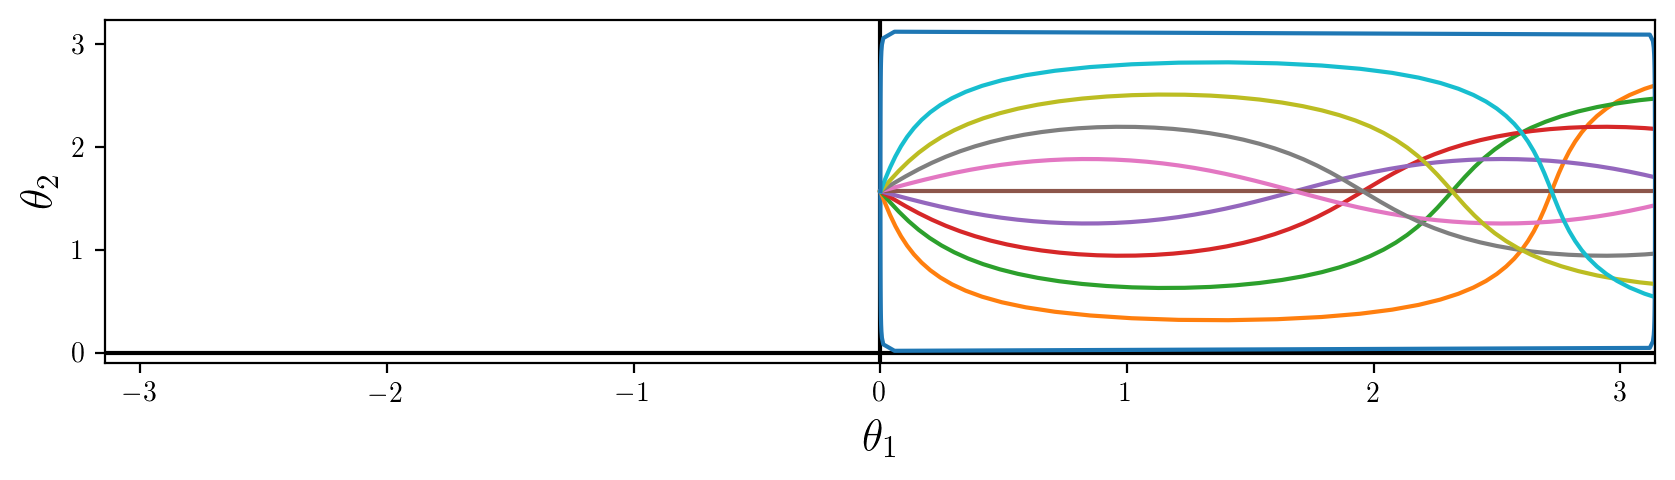

In [9]:
# Geodesics

#
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(r'$\theta_1$', fontsize=16)
ax1.set_ylabel(r'$\theta_2$', fontsize=16)
ax1.axhline(0, color='k')
ax1.axvline(0, color='k')
plt.ylim(-0.1, np.pi+0.1);
plt.xlim(-np.pi, np.pi);

#
N     = 100
tf    = 2.0*np.pi
tspan = list(np.linspace(t0, tf, N+1))

# 
alphas = np.linspace(-np.pi/2+1e-3, np.pi/2-1e-3, 11)

for alpha in alphas:
#
#alpha = np.pi/3.0
    p0  = p0init(x0, alpha)
    xf, pf = f(t0, x0, p0, tspan)
    xf = np.array(xf)
    ax1.plot(xf[:,0], xf[:,1])


## Wavefronts

In [10]:
# Wavefronts function

def wf(x, alpha, tf):
    p0    = p0init(x0, float(alpha))
    xf, _ = f(t0, x0, p0, tf)
    return x - xf

def dwf(x, dx, alpha, dalpha, tf):
    p0  = p0init(x0, float(alpha))
    dp0 = dp0init(x0, float(alpha), float(dalpha))
    (xf, dxf), _ = f(t0, x0, (p0, dp0), tf)
    return x-xf, dx - dxf
    
wf = nt.tools.tensorize(dwf, tvars=(1, 2), full=True)(wf)


     Calls  |f(x,pars)|     |x|                Homotopic param    Arclength s     det A(s)        Dot product                
 
         1  0.00000000e+00  3.25807913394e+00 -1.57069632679e+00  0.00000000e+00 -2.11617159e+00  0.00000000e+00
         2  4.88554687e-08  3.24877947716e+00 -1.56551906608e+00  1.09561130e-02 -2.11616014e+00  9.99981574e-01
         3  5.40589343e-08  3.23573593360e+00 -1.55823760471e+00  2.63638823e-02 -2.11585212e+00  9.99963618e-01
         4  6.04143853e-08  3.18131843021e+00 -1.52755786387e+00  9.12270594e-02 -2.11182274e+00  9.99351380e-01
         5  6.13265543e-08  3.07081183175e+00 -1.46309355768e+00  2.26750945e-01 -2.08996356e+00  9.97055148e-01
         6  6.03076321e-08  2.95466328986e+00 -1.39023326260e+00  3.77594215e-01 -2.04832672e+00  9.95954591e-01
         7  6.02967573e-08  2.83922384763e+00 -1.30872962428e+00  5.42258456e-01 -1.99165697e+00  9.94414880e-01
         8  5.99510374e-08  2.73951535811e+00 -1.22487203758e+00  7.06873848e-01

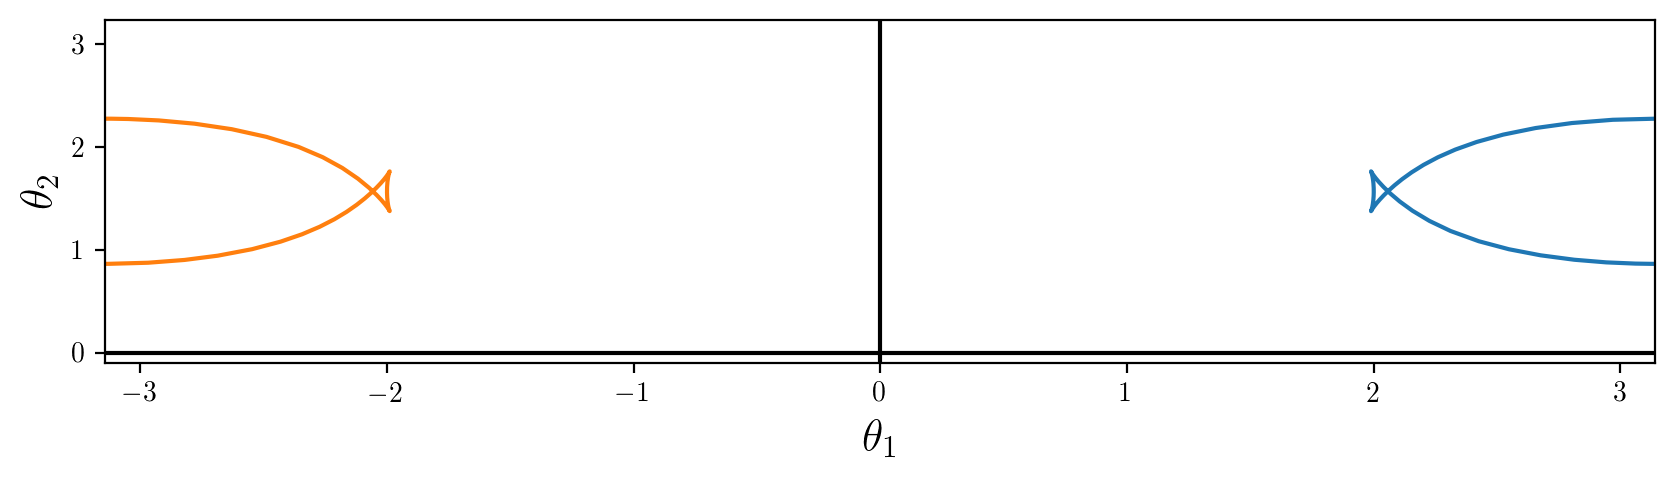

In [11]:
# options
opt = nt.path.Options(Display='on', MaxStepSizeHomPar=0.1, MaxIterCorrection=0);

#
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(r'$\theta_1$', fontsize=16)
ax1.set_ylabel(r'$\theta_2$', fontsize=16)
ax1.axhline(0, color='k')
ax1.axvline(0, color='k')
plt.ylim(-0.1, np.pi+0.1);
plt.xlim(-np.pi, np.pi);

#
epsi = 1e-4

# 
tf = 2

# 
# homotopic parameter range
alpha0  = -np.pi/2.0+epsi
alphaf  =  np.pi/2.0-epsi

# initial solution
p0 = p0init(x0, alpha0)
xf0, _ = f(t0, x0, p0, tf)

# wavefront computation
sol = nt.path.solve(wf, xf0, alpha0, alphaf, args=tf, options=opt, df=wf)

# wavefront plot
theta1 = sol.xout[:,0]
theta2 = sol.xout[:,1]
ax1.plot(theta1, theta2)

# 
# homotopic parameter range
alpha0  = np.pi/2.0+epsi
alphaf  = 3.0*np.pi/2.0-epsi

# initial solution
p0 = p0init(x0, alpha0)
xf0, _ = f(t0, x0, p0, tf)

# wavefront computation
sol = nt.path.solve(wf, xf0, alpha0, alphaf, args=tf, options=opt, df=wf)

# wavefront plot
theta1 = sol.xout[:,0]
theta2 = sol.xout[:,1]
ax1.plot(theta1, theta2)


[thumbnail](ellipsoid.png)